In [12]:
import sklearn.metrics as metrics
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn import preprocessing, svm
from evaluacion_funciones import *

from sklearn.dummy import DummyClassifier

In [13]:
# Carga de datos.
datos = load_iris()
X = datos.data
y = datos.target
print(np.shape(X))

(150, 4)


In [14]:
# Métricas de evaluación.
metricas = {
  'ACC':    metrics.accuracy_score,
  'PREC':   lambda y_true, y_pred:
            metrics.precision_score(y_true, y_pred,
              average='micro'),
  'RECALL': lambda y_true, y_pred:
            metrics.recall_score(y_true, y_pred,
              average='micro'),
  'F1':     lambda y_true, y_pred:
            metrics.f1_score(y_true, y_pred, average='micro')}

In [15]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_training))

(120, 4)


In [16]:
# ------------- TRAINING ---------------- #

In [17]:
# 2) Extracción de características

In [18]:
# 3) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
stdr_trained = standardizer.fit(X_training)
X_stdr = stdr_trained.transform(X_training)
# print(X_stdr)

In [19]:
# 4) Selección de atributos

In [20]:
# 5) Construcción del algoritmo de aprendizaje.
algoritmos = {'SVM': svm.SVC(C=10, random_state=42, probability=True),
             'DUMMY': DummyClassifier(strategy='stratified', random_state=42)}

In [21]:
# 5.1) Validación cruzada interna y Optimización de los hiperparámetros
# y_pred = {}
for nombre, alg in algoritmos.items():
#     y_pred[nombre] = cross_val_predict(alg, X_stdr, y_training, cv=KFold(n_splits=10, shuffle=True, random_state=42))
#     results = evaluacion(y_training, y_pred[nombre], metricas)
#     print(metrics.confusion_matrix(y_training, y_pred[nombre]))

    results = cross_val_score(alg, X_stdr, y_training, cv = KFold(n_splits=10, shuffle=True, random_state=42))
    print("Accuracy:   %0.4f +/- %0.4f" % (results.mean(), results.std()))

Accuracy:   0.9667 +/- 0.0553
Accuracy:   0.3167 +/- 0.1333


In [22]:
# 5.2) Entrenamiento del modelo definitivo
models = {}
for nombre, alg in algoritmos.items():
    models[nombre] = alg.fit(X_stdr, y_training)

In [23]:
# ------------- PREDICTION ---------------- #

In [24]:
# 6) Extracción de las características de test

In [25]:
# 7) Estandarización de las característiacs de test
X_test_stdr = stdr_trained.transform(X_testing)

In [26]:
# 8) Selección de los atributos de test 

In [27]:
# 9) Predicción del conjunto de test
y_pred = {}
for nombre, alg in models.items():
    y_pred[nombre] = alg.predict(X_test_stdr)

print(y_pred)

{'SVM': array([1, 0, 2, 1, 1, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0]), 'DUMMY': array([2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 0, 0, 1,
       0, 1, 1, 0, 2, 2, 1, 0])}


In [28]:
# 10) Evaluación del modelo sobre el conjunto de test
for nombre, alg in models.items():
    print(metrics.confusion_matrix(y_testing, y_pred[nombre]))

[[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
[[5 3 2]
 [1 4 4]
 [3 6 2]]


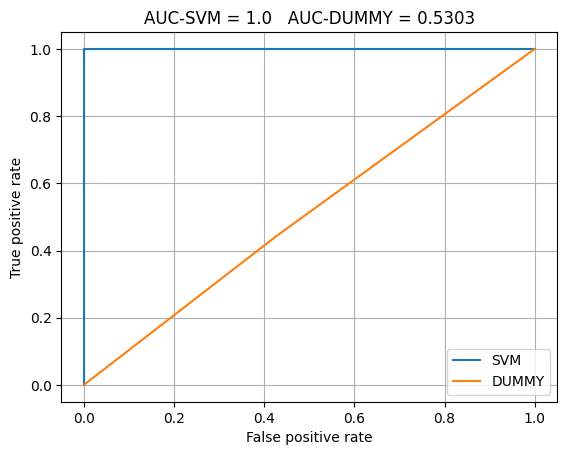

In [29]:
# Ploteamos la curva ROC
y_proba_svm = models['SVM'].predict_proba(X_test_stdr) # "predict_proba" para extraer probabilidades vez de predicciones
y_test_bin = preprocessing.label_binarize(y_testing, classes=[0,1,2]) # Usar "label_binarize" en el caso de problemas multiclase
auc_svm = metrics.roc_auc_score(y_testing, y_proba_svm, multi_class='ovr') # Area Under the ROC curve (AUC)
fpr_svm, tpr_svm, th_svm = metrics.roc_curve(y_test_bin[:,1], y_proba_svm[:,1])

y_proba_dummy = models['DUMMY'].predict_proba(X_test_stdr) # "predict_proba" para extraer probabilidades vez de predicciones
auc_dummy = metrics.roc_auc_score(y_testing, y_proba_dummy, multi_class='ovr') # Area Under the ROC curve (AUC)
fpr_dummy, tpr_dummy, th = metrics.roc_curve(y_test_bin[:,1], y_proba_dummy[:,1])

plt.plot(fpr_svm, tpr_svm)
plt.plot(fpr_dummy, tpr_dummy)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC-SVM = ' + str(np.round(auc_svm,4)) + '   AUC-DUMMY = ' + str(np.round(auc_dummy,4)))
plt.legend(['SVM', 'DUMMY'])
plt.grid()
plt.show()

In [30]:
# Tabla de resultados
from tabulate import tabulate
headers = ['','SVM', 'Dummy']
P,S,FS,ACC = ['Precision'], ['Recall'], ['F1-score'], ['Accuracy']

for nombre, alg in models.items():
    P.append(np.round(metrics.precision_score(y_testing, y_pred[nombre], average='macro'),4))
    S.append(np.round(metrics.recall_score(y_testing, y_pred[nombre], average='macro'),4))
    FS.append(np.round(metrics.f1_score(y_testing, y_pred[nombre], average='macro'),4))
    ACC.append(np.round(metrics.accuracy_score(y_testing, y_pred[nombre]),4))

my_data = [tuple(P), tuple(S), tuple(FS), tuple(ACC)]
print(tabulate(my_data, headers=headers))

              SVM    Dummy
---------  ------  -------
Precision  0.9722   0.3711
Recall     0.963    0.3754
F1-score   0.9659   0.3668
Accuracy   0.9667   0.3667
